In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import datetime
import pickle

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



读取处理过的数据，保留数据齐全的数据，调整时间格式

In [2]:
df = pd.read_excel('micro_rv_jpy.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)


In [3]:
columns = []
for i in [1,2]:
    columns.append(str(i)+'W')
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')


for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40]:
    columns.append(str(i)+'Y')

for old_name, new_name in zip(df.columns, columns):
    df.rename(columns={old_name: new_name}, inplace=True)

将各期限转为年为单位，并构建dictionary

In [4]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52,2/52,1/12,2/12,5/12,6/12, 7/12, 8/12, 9/12, 10/12,11/12, 12/12,  18/12,  2, 3, 4, 5, 6, 7, 8, 9, 10,12, 15, 20, 25, 30, 40])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])
date = df.index[0]
y = df.loc[date, selected_tenors].values

In [5]:
x

array([1.92307692e-02, 3.84615385e-02, 8.33333333e-02, 1.66666667e-01,
       4.16666667e-01, 5.00000000e-01, 5.83333333e-01, 6.66666667e-01,
       7.50000000e-01, 8.33333333e-01, 9.16666667e-01, 1.00000000e+00,
       1.50000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
       9.00000000e+00, 1.00000000e+01, 1.20000000e+01, 1.50000000e+01,
       2.00000000e+01, 2.50000000e+01, 3.00000000e+01, 4.00000000e+01])

In [6]:
y

array([-0.023  , -0.0231 , -0.02375, -0.0238 , -0.0239 , -0.02375,
       -0.02472, -0.02447, -0.0225 , -0.02321, -0.02221, -0.02125,
       -0.015  , -0.0056 ,  0.01125,  0.0285 ,  0.045  ,  0.0645 ,
        0.0825 ,  0.107  ,  0.13125,  0.1569 ,  0.205  ,  0.2825 ,
        0.4    ,  0.4925 ,  0.5625 ,  0.6075 ], dtype=float32)

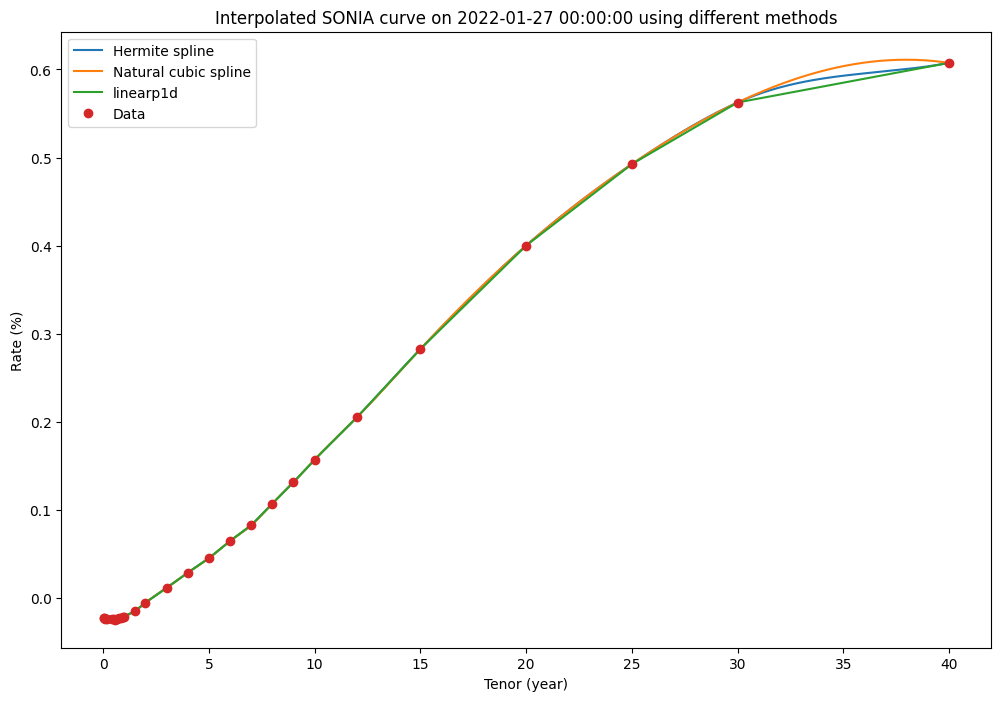

In [8]:
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,40,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date} using different methods')
plt.ylabel('Rate (%)')
plt.savefig("Example1.pdf",format = "pdf")

In [9]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [10]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.JAPAN
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F 
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F 

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
      swaps.append(swap)

In [11]:
swaps

[OBJECT TYPE: IborSwap
 OBJECT TYPE: SwapFixedLeg
 START DATE: 27-JAN-2022
 TERMINATION DATE: 27-JAN-2023
 MATURITY DATE: 27-JAN-2023
 NOTIONAL: 1000000
 PRINCIPAL: 0.0
 LEG TYPE: SwapTypes.PAY
 COUPON: -0.0002125000028172508
 FREQUENCY: FrequencyTypes.ANNUAL
 DAY COUNT: DayCountTypes.ACT_365F
 CALENDAR: CalendarTypes.JAPAN
 BUS DAY ADJUST: BusDayAdjustTypes.FOLLOWING
 DATE GEN TYPE: DateGenRuleTypes.BACKWARD
 
 OBJECT TYPE: SwapFloatLeg
 START DATE: 27-JAN-2022
 TERMINATION DATE: 27-JAN-2023
 MATURITY DATE: 27-JAN-2023
 NOTIONAL: 1000000
 SWAP TYPE: SwapTypes.RECEIVE
 SPREAD (BPS): 0.0
 FREQUENCY: FrequencyTypes.ANNUAL
 DAY COUNT: DayCountTypes.ACT_365F
 CALENDAR: CalendarTypes.JAPAN
 BUS DAY ADJUST: BusDayAdjustTypes.FOLLOWING
 DATE GEN TYPE: DateGenRuleTypes.BACKWARD,
 OBJECT TYPE: IborSwap
 OBJECT TYPE: SwapFixedLeg
 START DATE: 27-JAN-2022
 TERMINATION DATE: 27-JAN-2024
 MATURITY DATE: 29-JAN-2024
 NOTIONAL: 1000000
 PRINCIPAL: 0.0
 LEG TYPE: SwapTypes.PAY
 COUPON: -5.599999713012

Text(0.5, 1.0, 'Interpolated SONIA curve on 27-01-2022 for different rates')

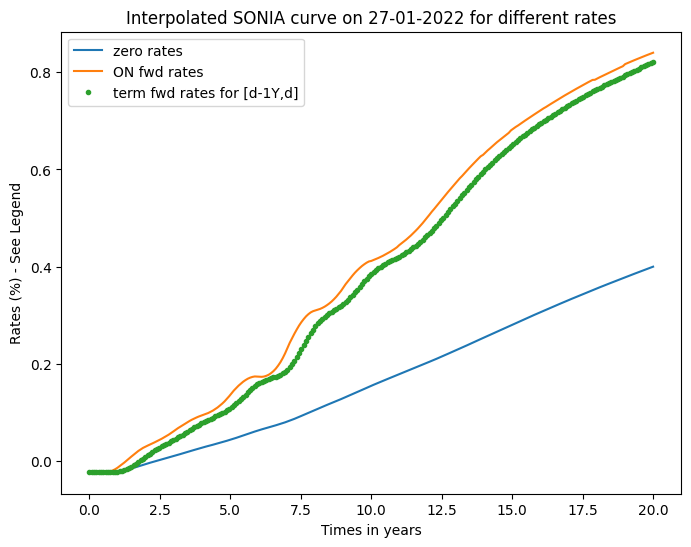

In [12]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")} for different rates')
#plt.savefig("example2.pdf",format="pdf")

In [13]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

In [14]:
year_columns

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40]

In [30]:
df = df.drop(df.index[7])  # Python is 0-indexed, so index 7 is the 8th row

In [32]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')])  # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns]  # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns)  # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY  # pay fixed
fixedDCCType = DayCountTypes.ACT_365F  # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL  # annual
floatFreqType = FrequencyTypes.ANNUAL  # annual
floatDCCType = DayCountTypes.ACT_365F  # 365 fixed

for date in tqdm(df.index, desc='Creating curves'):  # loop through each date in the dataset
    try:
        swaps = []
        day, month, year = date.day, date.month, date.year
        valuation_date = Date(day, month, year)  # convert to Date object
        spot_days = 0  # T+0
        settlement_date = valuation_date.add_weekdays(spot_days)
        for tenor in df.columns:  # loop through each tenor in the dataset
            if tenor[-1] == 'Y':
                rate = df.loc[date, tenor]/100 
                swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
                swaps.append(swap)

        curve = IborSingleCurve(valuation_date, ibor_deposits=[], ibor_fras=[], ibor_swaps=swaps, interp_type=InterpTypes.NATCUBIC_ZERO_RATES)
        for year in year_columns:
            df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date, maturity_dt=valuation_date.add_years(year))
        curves[date] = curve  # add this curve to the dictionary
    except Exception as e:
        print(f"Error on date {date}: {str(e)}")
        continue  # Skip this date and continue with the next one

Creating curves:   5%|▌         | 36/692 [00:23<07:05,  1.54it/s]/Users/cdsong/miniforge3/envs/myenv/lib/python3.10/site-packages/financepy/products/rates/ibor_swap.py:269: RuntimeWarning: invalid value encountered in scalar divide
  pv01 = pv / self.fixed_leg.cpn / self.fixed_leg.notional


Error on date 2022-03-28 00:00:00: Residuals are not finite in the initial point.


Creating curves:  15%|█▌        | 104/692 [01:06<04:55,  1.99it/s]

Error on date 2022-07-13 00:00:00: Residuals are not finite in the initial point.


Creating curves: 100%|██████████| 692/692 [07:22<00:00,  1.56it/s]


In [42]:
df_yield=df_yield.dropna()

In [43]:
df_yield.iloc[102:105]

,1,2,3,4,5,6,7,8,9,10,12,15,20,25,30,40
Date,,,,,,,,,,,,,,,,
2022-07-14,-3.749999812722242e-05,0.00042427996798181954,0.000775707976349464,0.0010631283921456428,0.001400868743336558,0.001876509243722208,0.0023881194678226363,0.0028756825728778255,0.003364557650000163,0.00422845904514378,0.004890857462195127,0.006392164075714252,0.00845581492162787,0.009643350757587928,0.010419705670239877,0.01102008358209035
2022-07-15,-0.00010093510473574676,0.0004990277357019174,0.0009258456942968252,0.0012383493355490952,0.001600879498237691,0.002087869088840512,0.002650595232178804,0.003150730157869772,0.003652235392990104,0.003965748534107089,0.005176738751567267,0.0066423480170965995,0.008525864947738198,0.009805970534864168,0.010557355725707927,0.011107525192062186
2022-07-19,-7.809999805418312e-05,0.00040054769419113504,0.0009871476859725432,0.001300107826662004,0.0016497395664832823,0.002139449786362793,0.0026770956136842505,0.003177181259959395,0.0036763503138675623,0.003877233058718336,0.005203880228287144,0.0066661236410165406,0.008755039909223133,0.009881573175284904,0.010645119375430228,0.0111952080773715


In [44]:
# store the curves dictionary and df_yield to a pickle file
with open('curves_jpy.pkl', 'wb') as f:
    pickle.dump(curves, f) # store the curves dictionary
df_yield.to_pickle('df_yield_jpy.pkl')